# ベイズの識別規則を図示する

1. 混合正規分布を生成  
   パラメータを設定(mean, var , pai)  
   
2. ベイズの識別規則から、識別関数を実装  
    識別境界をプロットする  
    この時、
    
比べるパラメータ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.datasets import load_breast_cancer

/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class CovarianceMatrix(pd.DataFrame):
    """
    共分散行列です。
    生成する際に自動で固有値・固有ベクトルを計算します。
    """
    @property
    def unique_val(self):
        """
        固有値のプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[0])
    
    @property
    def unique_vec(self):
        """
        固有ベクトルのプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[1])
    
    def _cal_unique(self):
        """
        固有値・固有ベクトルを計算します。
        """
        return np.linalg.eig(self.values)
    
    @staticmethod
    def compose(vec_var, vec_cov):
        """
        与えられた分散ベクトル・共分散ベクトルから、共分散行列を生成します。
        """
        return CovarianceMatrix([[vec_var[0]**2, vec_cov[0]], [vec_cov[0], vec_var[1] ** 2]])

    @staticmethod
    def genarate(nd_array: np.array):
        """
        与えられたデータから、共分散行列を生成します。
        """
        return CovarianceMatrix(np.cov(nd_array, rowvar=False))


/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8:

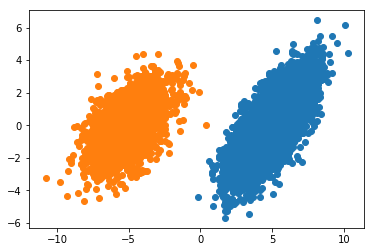

In [3]:
class Nomal(pd.DataFrame):
    """
    正規分布です。
    """
    def __init__(self, data=None, index=None, columns=None, dtype=None, copy=False, mean=None, cov=None, p=None, num=None):
        super().__init__(data=data, index=index, columns=columns, dtype=dtype, copy=copy)
        self.init_mean = mean
        self.init_cov = cov
        self.init_p = p
        self.init_num = num
    
    @staticmethod
    def create(vec_m, mat_cov, p, num):
        """
        平均ベクトルと共分散行列を指定して正規分布を生成します。

        :param vec_m 平均ベクトル
        :param mat_cov 共分散行列
        :param p 事前確率(生起確率)
        :param num データの個数
        """
        return Nomal(
            data=np.random.multivariate_normal(vec_m, mat_cov, round(p*num)),
            mean=vec_m,
            cov=mat_cov,
            p=p,
            num=num
        )
    
    @property
    def mean(self):
        return self.values.mean(axis=0)
    
    @property
    def cov(self):
        return CovarianceMatrix.genarate(self)

""" test """
num = 10000
cov = CovarianceMatrix([[1, 2], [2, 2]])
vec_mean = [5, 0]
p = 0.8
normal_c1 = Nomal.create(vec_m=vec_mean, mat_cov=cov, p=p, num=num)
plt.scatter(normal_c1.loc[:,0], normal_c1.loc[:,1])

cov = CovarianceMatrix([[1, 2], [2, 1]])
vec_mean = [-5, 0]
p = 0.2
normal_c2 = Nomal.create(vec_m=vec_mean, mat_cov=cov, p=p, num=num)
plt.scatter(normal_c2.loc[:,0], normal_c2.loc[:,1])
plt.show() 

In [4]:
def bayes(nd_x, nd_mean, nd_cov, vec_p):
    """
    ベイズの識別境界に基づき判別を行います。
    """
    S = np.linalg.inv(nd_cov[0]) - np.linalg.inv(nd_cov[1])
    c = nd_mean[0].T.dot(np.linalg.inv(nd_cov[0])) - nd_mean[1].T.dot(np.linalg.inv(nd_cov[1]))
    f1 = nd_mean[0].T.dot(np.linalg.inv(nd_cov[0])).dot(nd_mean[0]) - nd_mean[1].T.dot(np.linalg.inv(nd_cov[1])).dot(nd_mean[1])
    f2 = np.log(np.linalg.norm(nd_cov[0]) / np.linalg.norm(nd_cov[1])) - 2 * np.log(vec_p[0] / vec_p[1])
    F = f1 - f2
    item1 = np.diag(nd_x.T.dot(S).dot(nd_x))
    item2 =  - 2 * c.dot(nd_x)
#     print(f"item1: {item1.shape}")
#     print(f"item2: {item2.shape}")
#     print(f"F : {F}")
    return item1 + item2 + F

""" test """
nd_x = np.array(
    [[0, -5],
      [0, 5], 
      [0, -9]]
)
nd_mean = np.array(
    [[5, 0], 
      [-5, 0]]
)
nd_cov = np.array( [
    [[1, 2], [2, 1]], 
    [[1, 2], [2, 1]]
 ])
p = np.array([[0.8], [0.2]])
bayes(nd_x.T, nd_mean, nd_cov, p)

array([ 69.43925539, -63.89407794, 122.77258872])

In [5]:
def get_grid(xlim, ylim, num):
    """
    """
    range_x = [i for i in np.linspace(int(xlim[0]), int(xlim[1]), num)]
    range_y = [i for i in np.linspace(int(ylim[0]), int(ylim[1]), num)]
    ranges = (range_x, range_y)
    nd_x = np.meshgrid(range_x, range_y)
    return ranges, np.array(nd_x).reshape(2, nd_x[0].size)

def chose_range(df1, df2):
    """
    """
    xlim = (min(df1.min()[0], df2.min()[0]), max(df1.max()[0], df2.max()[0]))
    ylim = (min(df1.min()[1], df2.min()[1]), max(df1.max()[1], df2.max()[1]))
    return xlim, ylim
    

ranges = (-6.335708744360068, 0.36040973591167624)
result = get_grid(ranges, ranges, 10)
print(len(result[0]))

2


/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attr

<a list of 8 text.Text objects>

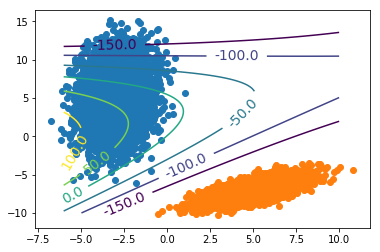

In [6]:
""" test """
num = 10000
vec_mean = [[-3, 5], [5, -7]]
cov1 = [[1, 0.5], 
               [0.5, 10]]
cov2 = [[2, 1], 
               [1, 1]]
nd_cov = [cov1, cov2]
p = [0.5, 0.5]

nomal_c1 = Nomal.create(vec_m=vec_mean[0], mat_cov=cov1, p=p[0], num=num)
nomal_c2 = Nomal.create(vec_m=vec_mean[1], mat_cov=cov2, p=p[1], num=num)

xlim, ylim = chose_range(nomal_c1, nomal_c2)
ranges, nd_x = get_grid(xlim, ylim, 200)
result = bayes(nd_x, nd_mean, nd_cov, p)

plt.scatter(nomal_c1.loc[:,0], nomal_c1.loc[:,1])
plt.scatter(nomal_c2.loc[:,0], nomal_c2.loc[:,1])
# cont = plt.contour(ranges[0], ranges[1], result.reshape(len(ranges[0]), len(ranges[1])))
cont = plt.contour(ranges[0], ranges[1], result.reshape(len(ranges[0]), len(ranges[1])), levels=[-150, -100, -50, 0, 50, 100, 150])
cont.clabel(fmt='%1.1f', fontsize=14)

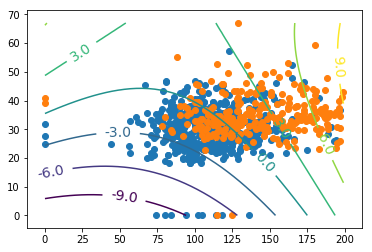

In [7]:
"""
ピマインディアンデータを使って教科書と同じようになるか検証してみる
"""
def get_data() -> pd.DataFrame:
    '''
    データセットを作成します
    '''
    diabetes = pd.read_table(
        "https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/pima-indians-diabetes.txt"
    )
    df_origin = diabetes.rename(columns={"OralGluTol":"glu", "BMI":"bmi", "Class":"type"})
    df_train = pd.DataFrame([])
    df_train['glu'] = df_origin['glu'] 
    df_train['bmi'] = df_origin['bmi'] 
    df_train['target'] = df_origin['type'] 
    return df_train

""" load data """
df_origin = get_data()
df_train_c1 = df_origin[df_origin['target'] == 0].drop('target', axis=1)
df_train_c2 = df_origin[df_origin['target'] == 1].drop('target', axis=1)

""" init param """
cov_c1 = CovarianceMatrix.genarate(df_train_c1)
cov_c2 = CovarianceMatrix.genarate(df_train_c2)

nomal_c1 = Nomal(data=df_train_c1)
nomal_c2 = Nomal(data=df_train_c2)

mean = [nomal_c1.mean, nomal_c2.mean]
cov = [cov_c1, cov_c2]
p = [0.5, 0.5]

""" running """
xlim, ylim = chose_range(nomal_c1, nomal_c2)
ranges, nd_x = get_grid(xlim, ylim, 50)
result = bayes(nd_x, mean, cov, p)

""" plot """
plt.scatter(nomal_c1.loc[:, 'glu'], nomal_c1.loc[:,'bmi'])
plt.scatter(nomal_c2.loc[:, 'glu'], nomal_c2.loc[:,'bmi'])
cont = plt.contour(ranges[0], ranges[1], result.reshape(len(ranges[0]), len(ranges[1])))
cont.clabel(fmt='%1.1f', fontsize=14)
# plt.xlim(50, 200)
# plt.ylim(15, 50)
plt.show()

/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attr

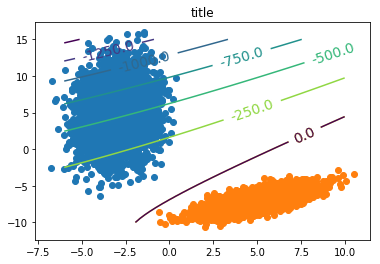

In [8]:
class Task():
    
    def __init__(self, discription, nomal1, nomal2):
        self.disc = discription
        self.nomal1 = nomal1
        self.nomal2 = nomal2
    
    def run(self, is_using_init=True):
        xlim, ylim = chose_range(self.nomal1, self.nomal2)
        ranges, nd_x = get_grid(xlim, ylim, 50)
        p = [self.nomal1.init_p, self.nomal2.init_p]
        
        if is_using_init:
            mean = [self.nomal1.init_mean, self.nomal2.init_mean]
            cov = [self.nomal1.init_cov, self.nomal2.init_cov]
        else:
            mean = [self.nomal1.mean, self.nomal2.mean]
            cov = [self.nomal1.cov, self.nomal2.cov]
        
        result = bayes(nd_x, mean, cov, p)
        plt.scatter(self.nomal1.loc[:, 0], self.nomal1.loc[:,1])
        plt.scatter(self.nomal2.loc[:, 0], self.nomal2.loc[:,1])
        cont = plt.contour(ranges[0], ranges[1], result.reshape(len(ranges[0]), len(ranges[1])))
        cont.clabel(fmt='%1.1f', fontsize=14)
        cont = plt.contour(ranges[0], ranges[1], result.reshape(len(ranges[0]), len(ranges[1])), levels=[0])
        cont.clabel(fmt='%1.1f', fontsize=14)
        plt.title(self.disc)
        plt.show()

""" test """
num = 10000
vec_mean = np.array([[-3, 5], [5, -7]])
cov1 = [[1, 0.5], 
               [0.5, 10]]
cov2 = [[2, 1], 
               [1, 1]]
nd_cov = [cov1, cov2]
p = [0.5, 0.5]
nomal_c1 = Nomal.create(vec_m=vec_mean[0], mat_cov=cov1, p=p[0], num=num)
nomal_c2 = Nomal.create(vec_m=vec_mean[1], mat_cov=cov2, p=p[1], num=num)

Task('title', nomal_c1, nomal_c2).run()

/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attr

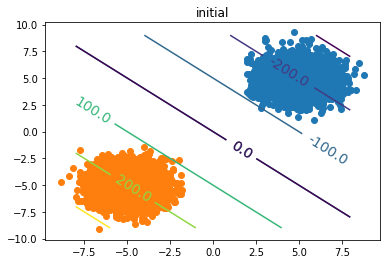

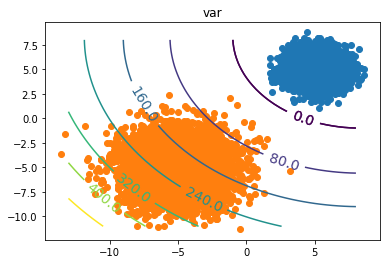

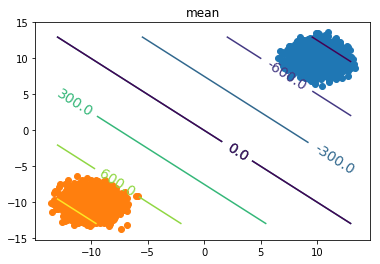

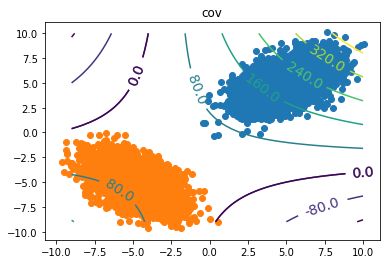

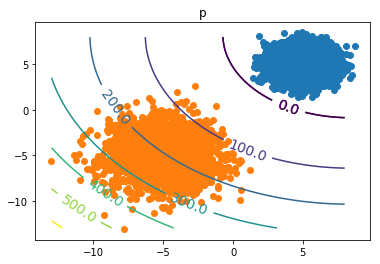

In [9]:
num = 10000

mean1 = np.array([5, 5])
mean2 = np.array([-5, -5])
mean3 = np.array([10, 10])
mean4 = np.array([-10, -10])

cov1 = CovarianceMatrix.compose([1, 1], [0])
cov2 = CovarianceMatrix.compose([2, 2], [0])
cov3 = CovarianceMatrix.compose([1, 1], [2])
cov4 = CovarianceMatrix.compose([1, 1], [-2])

p1 = [0.5, 0.5]
p2 = [0.8, 0.2]

nomal1 = Nomal.create(vec_m=mean1, mat_cov=cov1, p=p1[0], num=num)
nomal2 = Nomal.create(vec_m=mean2, mat_cov=cov1, p=p1[1], num=num)

nomal11 = Nomal.create(vec_m=mean1, mat_cov=cov1, p=p1[0], num=num)
nomal12 = Nomal.create(vec_m=mean2, mat_cov=cov2, p=p1[1], num=num)

nomal21 = Nomal.create(vec_m=mean3, mat_cov=cov1, p=p1[0], num=num)
nomal22 = Nomal.create(vec_m=mean4, mat_cov=cov1, p=p1[1], num=num)

nomal31 = Nomal.create(vec_m=mean1, mat_cov=cov3, p=p1[0], num=num)
nomal32 = Nomal.create(vec_m=mean2, mat_cov=cov4, p=p1[1], num=num)

nomal41 = Nomal.create(vec_m=mean1, mat_cov=cov1, p=p2[0], num=num)
nomal42 = Nomal.create(vec_m=mean2, mat_cov=cov2, p=p2[1], num=num)

Task('initial', nomal1=nomal1, nomal2=nomal2).run()
Task('var', nomal1=nomal11, nomal2=nomal12).run()
Task('mean', nomal1=nomal21, nomal2=nomal22).run()
Task('cov', nomal1=nomal31, nomal2=nomal32).run()
Task('p', nomal1=nomal41, nomal2=nomal42).run(is_using_init=False)
